This notebook calculate correlation length xi for each k

In [1]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
from scipy import signal
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook

In [4]:
reg = np.load('reg_ref.npy') # load reference mask for sample
tbmapk = hs.load('results/tbmap_nk_2d.hspy')

In [5]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [6]:
from skimage.morphology import binary_dilation

In [7]:
def erode_layer(mask,layers=1):
    # remove scattered points in sample mask
    eroded_mask = mask
    for _ in range(layers):
        mask_old = eroded_mask
        eroded_mask = binary_dilation(mask_old)
    return eroded_mask

In [8]:
def get_corr2d(tmap,ref=None):
    # returns 2d spatial correlation function
    # tmap: tau map data
    # ref: sample mask
    tmap0[tmap0<1] = 1
    tmap0 = np.log10(tmap0)
    tmap1 = (tmap0 - np.min(tmap0)) / (np.max(tmap0) - np.min(tmap0))
    
    tmapfft = np.fft.fft2(tmap1)/tmap.shape[0]/tmap.shape[1]
    
    g = np.fft.fftshift(np.fft.ifft2(tmapfft*tmapfft.conj()).real*tmap.shape[0]*tmap.shape[1])
    
    corr = g/np.mean(tmap1)**2-1
    return corr

In [9]:
tbmapk

<Signal1D, title: , dimensions: (36, 16, 160, 160|5)>

<IPython.core.display.Javascript object>


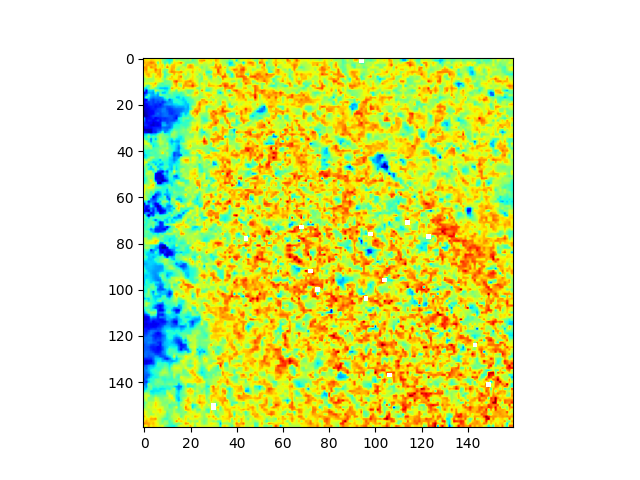

/srv/home/shuang375/anaconda3/envs/4dstem/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [10]:
plt.figure()
plt.imshow(np.log10(tbmapk.inav[2,2].isig[0].data),cmap='jet_r')

In [11]:
from skimage.transform import warp_polar

### Calculate correlation functions from three squared area inside the wire

In [129]:
cxy1 = np.array([get_corr2d(tbmapk.inav[j,i].isig[0].data[30:70,40:80]) for i in range(16) for j in np.r_[22:36,:15]]).reshape(16,29,40,40)
cxy2 = np.array([get_corr2d(tbmapk.inav[j,i].isig[0].data[45:85,85:125]) for i in range(16) for j in np.r_[22:36,:15]]).reshape(16,29,40,40)
cxy3 = np.array([get_corr2d(tbmapk.inav[j,i].isig[0].data[90:130,80:120]) for i in range(16) for j in np.r_[22:36,:15]]).reshape(16,29,40,40)

<IPython.core.display.Javascript object>


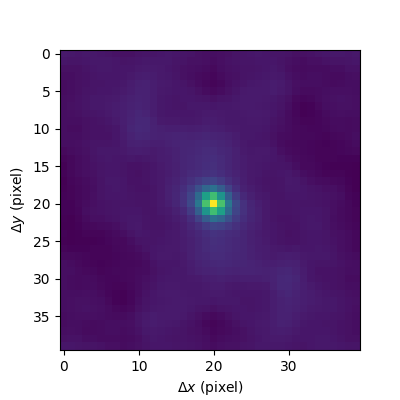

In [44]:
plt.figure(figsize=(4,4))
plt.imshow(np.mean(cxy2[8],axis=0))
#plt.xticks([5,15,25,35,45],labels=[-20,-10,0,10,20])
#plt.yticks([5,15,25,35,45],labels=[20,10,0,-10,-20])
plt.xlabel(r'$\Delta x$ (pixel)')
plt.ylabel(r'$\Delta y$ (pixel)')
plt.subplots_adjust(left=0.15,bottom=.12)

In [130]:
cr1 = np.array([warp_polar(c,radius=20).mean(axis=0) for c in cxy1.reshape(16*29,40,40)]).reshape(16,29,20)
cr2 = np.array([warp_polar(c,radius=20).mean(axis=0) for c in cxy2.reshape(16*29,40,40)]).reshape(16,29,20)
cr3 = np.array([warp_polar(c,radius=20).mean(axis=0) for c in cxy3.reshape(16*29,40,40)]).reshape(16,29,20)

In [15]:
def gaussian(x,a,c):
    return a*np.exp(-x**2/2/c**2)

In [16]:
def gauss_fitting(g,t,c_guess):
    try:
        popt, pcov = curve_fit(gaussian, t, g, p0 = [np.max(g)-np.min(g),c_guess])
        fw = 2*np.sqrt(2*np.log(2))
        return [popt[-1]*fw,np.sqrt(pcov[-1,-1])*fw]
    except:
        return [0,0]

### Use Gaussian FWHM as correlation length estimates

In [20]:
xig = np.array([[gauss_fitting(np.mean([cr1[i,j],cr2[i,j],cr3[i,j]],axis=0),np.linspace(0,44.9,160)[:20],1) for i in range(16)] for j in range(29)])

In [18]:
klist = np.array([0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 ,
       0.52, 0.54, 0.56, 0.58, 0.6 ])

<IPython.core.display.Javascript object>


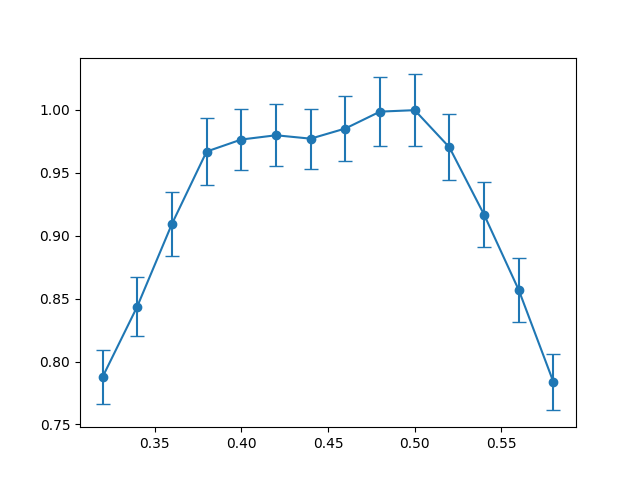

<ErrorbarContainer object of 3 artists>

In [29]:
plt.figure()
plt.errorbar(klist[1:-1],np.mean(xig,axis=0)[1:-1,0],yerr=xig.mean(axis=0)[1:-1,1],marker='o',capsize=5)

In [216]:
np.save('results/xi_tk_kphi.npy',xig)